# Develop a Fake or Real Discriminator

In this notebook, we walk through the steps of developing a machine learning model that is trained to distinguish between fake (=synthetic) and real records. The model's ability to correctly discriminate between these on an unseen holdout can serve us as another helpful quality criteria for the generated synthetic data. The more realistic those synthetic records are, the harder it will be for any discriminator to tell these apart from the real records.

<img src='https://raw.githubusercontent.com/mostly-ai/mostly-tutorials/dev/fake-or-real/fake-or-real.png' width="400px"/>

In order to make the analysis more interesting, we intentionally create synthetic data of lower quality, by limiting the training samples to only a thousand records. Otherwise, the discriminator would not be able to find much signal, if the synthesizer, like MOSTLY AI, is of very high quality.

## Synthesize Data via MOSTLY AI

For this tutorial, we will be using again the UCI Adult Income [[1](#refs)] dataset, which consists of 48842 records across 15 attributes.

1. Download `census-49k.csv` by clicking [here](https://github.com/mostly-ai/mostly-tutorials/raw/dev/fake-or-real/census-49k.csv), and then press Ctrl+S to save locally.

2. Synthesize `census-49k.csv` via [MOSTLY AI](https://mostly.ai/), but limit training samples to 1000 records.

<img src='https://raw.githubusercontent.com/mostly-ai/mostly-tutorials/dev/fake-or-real/screen1.png' width="400px"/>

3. Once the job has finished, download the generated synthetic data as CSV file to your computer.

4. Upload the generated synthetic data to this Notebook via executing the next cell.

In [1]:
# upload synthetic dataset
import pandas as pd
try:
    # check whether we are in Google colab
    from google.colab import files
    print("running in COLAB mode")
    repo = 'https://github.com/mostly-ai/mostly-tutorials/raw/dev/fake-or-real'
    import io
    uploaded = files.upload()
    syn = pd.read_csv(io.BytesIO(list(uploaded.values())[0]))
    print(f"uploaded synthetic data with {syn.shape[0]:,} records and {syn.shape[1]:,} attributes")
except:
    print("running in LOCAL mode")
    repo = '.'
    print("adapt `syn_file_path` to point to your generated synthetic data file")
    syn_file_path = './census-synthetic-1k.csv'
    syn = pd.read_csv(syn_file_path)
    print(f"read synthetic data with {syn.shape[0]:,} records and {syn.shape[1]:,} attributes")

running in LOCAL mode
adapt `syn_file_path` to point to your generated synthetic data file
read synthetic data with 48,842 records and 14 attributes


## Train Discriminator

In [2]:
import lightgbm as lgb
from lightgbm import early_stopping
from sklearn.model_selection import train_test_split

def prepare_xy(df, target_col, target_val):
    # split target variable `y`
    y = (df[target_col]==target_val).astype(int)
    # convert strings to categoricals, and all others to floats
    str_cols = [col for col in df.select_dtypes(['object', 'string']).columns if col != target_col]
    for col in str_cols:
        df[col] = pd.Categorical(df[col])
    cat_cols = [col for col in df.select_dtypes('category').columns if col != target_col]
    num_cols = [col for col in df.select_dtypes('number').columns if col != target_col]
    for col in num_cols:
        df[col] = df[col].astype('float')
    X = df[cat_cols + num_cols]
    return X, y

def train_model(X, y):
    cat_cols = list(X.select_dtypes('category').columns)
    X_trn, X_val, y_trn, y_val = train_test_split(X, y, test_size=0.2, random_state=1)
    ds_trn = lgb.Dataset(X_trn, label=y_trn, categorical_feature=cat_cols, free_raw_data=False)
    ds_val = lgb.Dataset(X_val, label=y_val, categorical_feature=cat_cols, free_raw_data=False)
    model = lgb.train(
        params={
            'verbose': -1,
            'metric': 'auc',  
            'objective': 'binary'
        },
        train_set=ds_trn,
        valid_sets=[ds_val],
        callbacks=[early_stopping(5)],
    )
    return model

import warnings
warnings.filterwarnings('ignore')

In [3]:
# concatenate FAKE and REAL data together
tgt = pd.read_csv(f'{repo}/census-49k.csv')
df = pd.concat([
    tgt.assign(split='REAL'),
    syn.assign(split='FAKE'),
], axis=0)
df.insert(0, 'split', df.pop('split'))
df.groupby('split').size()

split
FAKE    48842
REAL    48842
dtype: int64

In [4]:
# take a 20% holdout dataset aside for evaluation
trn, hol = train_test_split(df, test_size=0.2, random_state=1)

In [5]:
# train the discriminator on the remaining 80% training dataset
X_trn, y_trn = prepare_xy(trn, 'split', 'FAKE')
model = train_model(X_trn, y_trn)

Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's auc: 0.805876


In [6]:
# score the model on the holdout dataset, assigning a probability to each record on whether it's FAKE or REAL
X_hol, y_hol = prepare_xy(hol, 'split', 'FAKE')
hol.insert(1, 'is_fake', model.predict(X_hol).round(4))

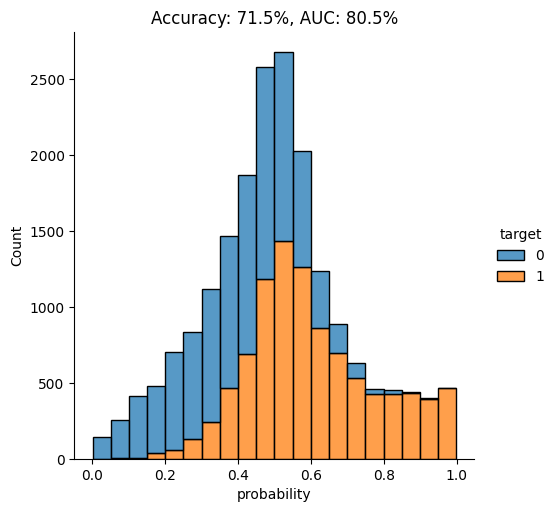

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, accuracy_score

auc = roc_auc_score(y_hol, hol.is_fake)
acc = accuracy_score(y_hol, (hol.is_fake>0.5).astype(int))
probs_df = pd.concat([
    pd.Series(hol.is_fake, name='probability').reset_index(drop=True),
    pd.Series(y_hol, name='target').reset_index(drop=True)
], axis=1)
fig = sns.displot(data=probs_df, x='probability', hue='target', bins=20, multiple="stack")
fig = plt.title(f"Accuracy: {acc:.1%}, AUC: {auc:.1%}")
plt.show()

As you can see from above chart, the discriminator has learned to pick up some signals that allow it with a varying level of confidence to determine whether a record is FAKE or REAL. 

The AUC can be interpreted as the percentage of cases, where the discriminator is able to correctly spot the FAKE record, given a set of a FAKE and a REAL record.

#### Sample records, that seem very FAKE

In [8]:
hol.sort_values('is_fake').tail(n=100).sample(n=5)

,split,is_fake,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
45664,FAKE,0.9905,35.0,Private,11th,5.0,Married-civ-spouse,Sales,Husband,White,Male,0.0,1617.0,40.0,United-States,>50K
47434,FAKE,0.9882,50.0,Federal-gov,Assoc-voc,16.0,Married-civ-spouse,Sales,Husband,White,Male,0.0,0.0,40.0,United-States,>50K
30558,FAKE,0.9896,35.0,Self-emp-inc,Assoc-acdm,10.0,Married-civ-spouse,Prof-specialty,Wife,White,Female,15054.0,0.0,50.0,United-States,>50K
34711,FAKE,0.9921,53.0,Private,Assoc-acdm,16.0,Never-married,Prof-specialty,Not-in-family,White,Female,0.0,0.0,40.0,United-States,<=50K
8301,FAKE,0.9935,57.0,Private,Assoc-acdm,15.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,40.0,United-States,>50K


In these cases, it is the mismatch between `education` and `education_num` that gives away the fact that these are FAKE. In the original data, education level `Assoc-acdm` was mapped to education number 12, whereas in the synthetic data we see various other numeric values.

In [9]:
pd.crosstab(tgt.education, tgt.education_num)

education_num,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
education,,,,,,,,,,,,,,,,
10th,0,0,0,0,0,1389,0,0,0,0,0,0,0,0,0,0
11th,0,0,0,0,0,0,1812,0,0,0,0,0,0,0,0,0
12th,0,0,0,0,0,0,0,657,0,0,0,0,0,0,0,0
5th-6th,0,0,509,0,0,0,0,0,0,0,0,0,0,0,0,0
7th-8th,0,0,0,955,0,0,0,0,0,0,0,0,0,0,0,0
9th,0,0,0,0,756,0,0,0,0,0,0,0,0,0,0,0
Assoc-acdm,0,0,0,0,0,0,0,0,0,0,0,1601,0,0,0,0
Assoc-voc,0,0,0,0,0,0,0,0,0,0,2061,0,0,0,0,0
Bachelors,0,0,0,0,0,0,0,0,0,0,0,0,8025,0,0,0


In [10]:
pd.crosstab(syn.education, syn.education_num)

education_num,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
education,,,,,,,,,,,,,,,
10th,74,40,15,16,1041,51,72,53,2,0,1,0,1,0,1
11th,25,3,45,91,45,1909,119,19,0,0,0,0,0,0,0
12th,89,13,64,73,164,152,135,6,0,0,4,0,2,0,3
5th-6th,4,269,39,23,24,19,6,106,0,0,0,12,2,0,4
7th-8th,75,41,237,96,87,133,52,23,0,1,11,3,18,3,6
9th,43,22,63,104,62,86,28,2,0,1,4,1,1,3,4
Assoc-acdm,5,5,6,3,3,2,4,0,6,298,528,9,346,182,213
Assoc-voc,1,0,0,0,0,0,0,0,91,1188,269,2,114,33,180
Bachelors,0,1,0,0,0,0,0,0,9,1,1,8039,23,2,0


#### Sample records, that seem very REAL

I.e. these are type of records, that the synthesizer has apparently failed to create. Thus, as they are then absent from the synthetic data, the discriminator recognizes these as REAL.

In [11]:
hol.sort_values('is_fake').head(n=100).sample(n=5)

,split,is_fake,age,workclass,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
344,REAL,0.0181,44.0,Local-gov,Some-college,10.0,Married-civ-spouse,Protective-serv,Husband,Black,Male,0.0,0.0,99.0,United-States,<=50K
33684,REAL,0.0262,53.0,Private,OTHER,1.0,Married-civ-spouse,Other-service,Husband,White,Male,0.0,0.0,40.0,Mexico,<=50K
42617,REAL,0.0153,90.0,Self-emp-not-inc,HS-grad,9.0,Never-married,Exec-managerial,Not-in-family,White,Male,2964.0,0.0,12.0,United-States,<=50K
8295,REAL,0.0331,44.0,Private,Prof-school,15.0,Divorced,Prof-specialty,Not-in-family,White,Female,2354.0,0.0,99.0,United-States,<=50K
44727,REAL,0.0128,78.0,Self-emp-inc,11th,7.0,Married-civ-spouse,Exec-managerial,Husband,White,Male,0.0,0.0,10.0,United-States,<=50K


## Conclusion

This tutorial has shown how to train a discriminator that is set out to distinguish between FAKE and REAL records. The better the quality of the generated synthetic data, the less likely the discriminator (as well as we humans) can tell them apart.

## Further exercises

In addition to walking through the above instructions, we suggest..
* measuring the Discriminator's AUC if more training samples are used
* using a different dataset, eg. the UCI bank-marketing dataset [[2](#refs)]
* using a different ML model for the discriminator, eg. a RandomForest model [[3](#refs)]
* using a different synthesizer, eg. SynthCity, SDV, etc.

## References<a class="anchor" name="refs"></a>

1. https://archive.ics.uci.edu/ml/datasets/adult
1. https://archive.ics.uci.edu/ml/datasets/bank+marketing
1. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html